In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import os
import sys
from datetime import datetime

#global declaration
FILE_NAME = '\youTubeVideoData_680473'
sns.set()

In [68]:
absolutepath = os.path.dirname(os.path.abspath("__file__"))
print(absolutepath)

fileDirectory = os.path.dirname(absolutepath)
print(fileDirectory)#Path of parent directory
parentDirectory = os.path.dirname(fileDirectory)
print(parentDirectory)
#Navigate to Strings directory
newPath = os.path.join(parentDirectory, 'data', 'raw')   
print(newPath)

C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\data\raw


In [70]:
# unzipping the datafile from data raw folder to 
with zipfile.ZipFile(newPath+FILE_NAME+'.zip',"r") as zip_ref:
    zip_ref.extractall(absolutepath)

In [126]:
df = pd.read_csv(absolutepath+FILE_NAME+'.csv', index_col=0, low_memory=False)

In [200]:
for column in df.columns:
    if (column.find('Count')>0): 
        df[column].replace('[]','0', inplace = True)
        df[column].replace('','0', inplace = True)
        df = df.astype({column:int})
    else:
        df = df.astype({column:str})

In [201]:
df.shape

(680473, 11)

In [202]:
df.dtypes

ContentId          object
title              object
viewCount           int32
likeCount           int32
dislikeCount        int32
commentCount        int32
publishedAt        object
description        object
topicCategories    object
duration           object
tags               object
dtype: object

In [203]:
(df['favoriteCount'] == 0). sum()

KeyError: 'favoriteCount'

In [204]:
df.drop('favoriteCount',axis =1, inplace = True)

KeyError: "['favoriteCount'] not found in axis"

In [205]:
#missing value check
df.isnull().sum().sum()

0

In [206]:
# df_plot = df.drop(['title'])
count_col = []
for column in df.columns:
    if (column.find('Count')<0):
        count_col.append(column)
df_eda = df.drop(count_col, axis = 1)
df_eda.columns.values
df_eda

,viewCount,likeCount,dislikeCount,commentCount
0,10814444,298544,11821,36687
1,1432519,48398,972,3475
2,20686975,297683,15042,22395
3,531332,21739,654,1592
4,386427,17893,274,407
...,...,...,...,...
149522,4655,125,4,27
150399,15018,439,12,58
150416,8493,261,14,11
161424,25228,1510,23,110


In [197]:
df_eda = df_eda.loc[~df.index.duplicated(), :]

In [194]:
df1

,viewCount,likeCount,dislikeCount,commentCount
0,10814444,298544,11821,36687
1,1432519,48398,972,3475
2,20686975,297683,15042,22395
3,531332,21739,654,1592
4,386427,17893,274,407
...,...,...,...,...
55723,1952,7,0,0
55925,4735,85,2,4
55940,571,1,0,1
56332,3635,27,2,2


In [210]:
df_eda.describe()
    

,viewCount,likeCount,dislikeCount,commentCount
count,6.804730e+05,6.804730e+05,6.804730e+05,6.804730e+05
mean,8.260607e+05,1.314470e+04,6.392983e+02,6.748293e+02
std,1.042544e+07,1.334828e+05,7.753941e+03,2.853102e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.574000e+03,2.500000e+01,2.000000e+00,2.000000e+00
50%,2.336700e+04,2.980000e+02,1.800000e+01,1.600000e+01
75%,1.707710e+05,2.381000e+03,1.260000e+02,1.100000e+02
max,1.372878e+09,3.104455e+07,1.766148e+06,1.595512e+07


In [ ]:
# count_feature = df_eda.select_dtypes(include=['category', int]).columns
# fig, ax = plt.subplots(2, 2, figsize=(25, 10))
# plt.subplots_adjust(hspace = 0.4)
# for col, subplot in zip(count_feature, ax.flatten()):
#     sns.boxplot(x=df_eda[col], ax=subplot)
# plt.show()
sns.boxplot(data = df_eda['viewCount'])

<Figure size 2160x2160 with 0 Axes>

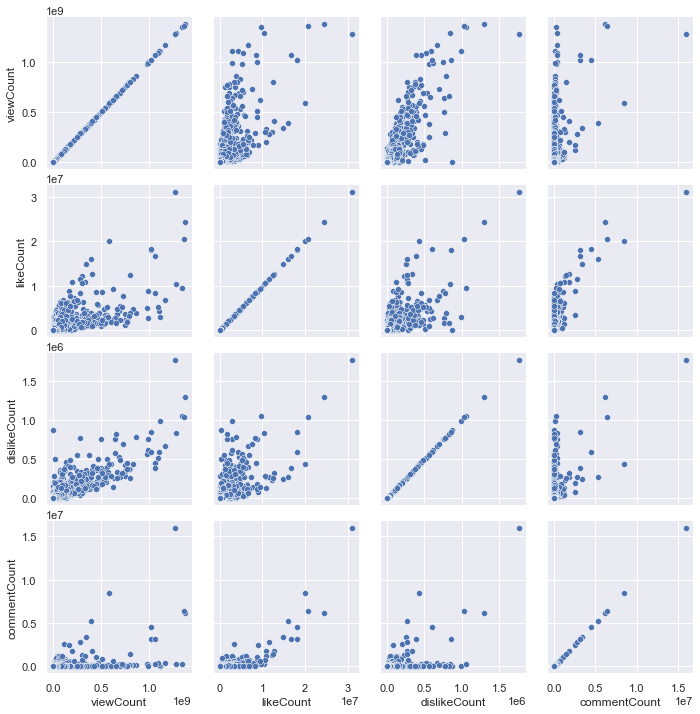

In [217]:
plt.figure(figsize=(30,30)) 
g=sns.PairGrid(df_eda)
g.map(sns.scatterplot)

<AxesSubplot:>

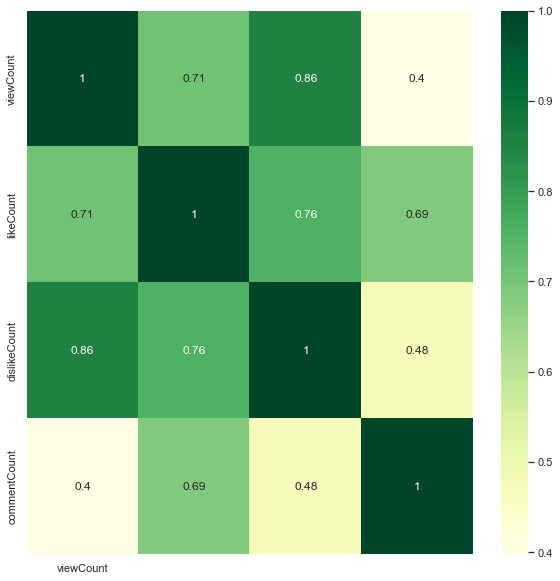

In [216]:
plt.figure(figsize=(15,29)) 
sns.heatmap(df_eda.corr(), annot=True,cmap = 'YlGn')

In [ ]:
# kde, dist, box for numerical data
# viewCount           int32
# likeCount          object
# dislikeCount       object
# commentCount       object
# favoriteCount       int64
seaborn joinplot .. wiht diag on box and diag on kde, heatmap...

word cloud for content title, tags and...
# viewCount           int32
# likeCount          object
# dislikeCount       object
# commentCount       object
# favoriteCount       int64

# Tentative
topic categories.
topic modeling..
datstime fromatting